In [1]:
!ls power_gpu_no_apus_installed_2/bigann-1B-T3.IVF1048576,SQ8.faissindex.gpu=1.time=1626288356.294076

1626288645.852447 1626288677.468892 1626288714.606822
1626288656.243020 1626288688.576803 1626288731.563087
1626288666.508528 1626288700.762235 data.txt


In [1]:
import pandas as pd
import os

#expdirs = ['power_gpu_no_apus_installed_2','power_no_gpu_or_apus_installed','power_gpu_no_apus_installed_msspace']
expdirs = ['power_gpu_no_apus_installed_3']

master_df = pd.DataFrame(columns=["db", "ts", "gpu", "recall", "qps", "wspq", "point" ])

# iterate all experiments
for expdir in expdirs:
    
    # iterate each dbase in the experiment
    for dbdir in os.listdir(expdir):
        
        # parse the directory name for dbname and gpu status
        parts = dbdir.split('.')
        print(parts)
        
#        print(parts)
        dbname = parts[1]
        print(dbname)
        gpu = int(parts[4].split('=')[1])
        ts = int(parts[5].split('=')[1])
        
        # filter experiments we don't care about
        if (dbname.find("1B")<0):
            print("skipping non 1B experiment", dbname)
            continue           
        
        # parse the main data file into a df
        expfile=os.path.join( expdir, dbdir, "data.txt")
        df = pd.read_csv(expfile, header=None)
        df.columns = [ "capts", "recall", "mspq", "mindur", "totpow", "totq", "wspq" ]   
        df = df.filter(items=[ "recall", "mspq", "wspq"])
 
        # get mspq, compute qps and add to df, remove mspq
        mspq = df['mspq'].tolist()
        qps = [ (1.0/t*1000.0) for t in mspq ]
        df['qps']= qps
        df.drop(columns=['mspq'])

        # add gpu usage to df
        df['gpu']=[gpu]*df.shape[0]

        # add dbname to df
        df['db']=[dbname]*df.shape[0]
        
        # add ts to df
        df['ts']=[ts]*df.shape[0]
        
        # add the point to the df
        df['point'] = range(0, df.shape[0])
        
        # accumulate to the master df
        master_df = master_df.append(df, ignore_index=True)
            
print(master_df)
print("There are %d rows" % master_df.shape[0])

['run', 'msturing-1B', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627008484', '394818']
msturing-1B
['run', 'bigann-1B-T3', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627012291', '851904']
bigann-1B-T3
['run', 'bigann-1B-T3', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627011753', '953215']
bigann-1B-T3
['run', 'msturing-1B', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627010541', '112087']
msturing-1B
['run', 'bigann-1B-T3', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627012649', '187257']
bigann-1B-T3
['run', 'text2image-1B', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627006080', '642148']
text2image-1B
['run', 'deep-1B', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627014493', '500697']
deep-1B
['run', 'text2image-1B', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627007573', '584924']
text2image-1B
['run', 'text2image-1B', 'IVF1048576,SQ8', 'faissindex', 'gpu=1', 'time=1627006978', '740282']
text2image-1B
['run', 'msspacev-1B', 'IVF1048576,SQ8', 'fai

          dbase   interp@2K-QPS      max recall
    msturing-1B        0.908963        0.946410
   bigann-1B-T3        0.926695        0.943890
  text2image-1B        0.865377        0.882487
        deep-1B        0.944868        0.947430
    msspacev-1B        0.858699        0.899860


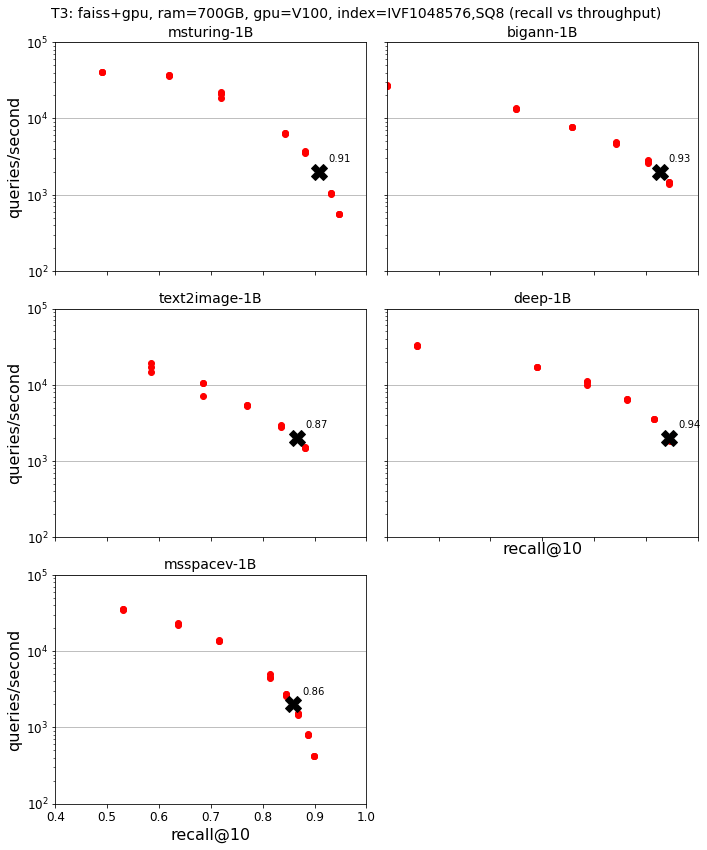

In [33]:
# Individual dbase plots
import numpy as np
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=16, titlesize=16)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams["figure.figsize"] = (10,12)
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = 'roman'
#print(plt.rcParams.keys())

fig, axs = plt.subplots(3,2, sharey=True, sharex=True)

dbs = master_df['db'].unique()
#print(dbs)

# iterate across databases
for didx, dbname in enumerate(dbs):
    
    # filter rows for just this db
    dbdf = master_df.loc[ master_df["db"] == dbname ] 
    
    # get the run IDs for the db
    tss = dbdf['ts'].unique()
    
    # track if only gpu runs were done for the db
    gpu_exclusive = True
    
    # iterate across the runs for the db
    for ts in tss:
        
        # get the df for the run
        runpdf = dbdf[ dbdf["ts"] == ts ]
        
        # get the gpu status to inform graphics
        gpu = runpdf["gpu"].tolist()
        # bypass gpu
        if gpu[0]==0: continue
        color = [ 'red' if i==1 else 'blue' for i in gpu ]    
        if gpu[0]==0: gpu_exclusive = False
        
        # get the list of recalls and qps
        recall = runpdf["recall"].tolist()
        qps = runpdf["qps"].tolist()         

        # label only certain axes so as to not crowd the plot
        if didx==0: 
            ax = axs[0,0]
            ax.set_ylabel("queries/second")
            ax.set_xticklabels([])
        elif didx==1: 
            ax = axs[0,1] 
            ax.set_xticklabels([])
        elif didx==2:    
            ax = axs[1,0]      
            ax.set_ylabel("queries/second") 
            ax.set_xticklabels([])
        elif didx==3: 
            ax = axs[1,1]       
            ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
            ax.set_xticklabels([ str(i) for i in [0.4,0.5,0.6,0.7,0.8,0.9,1.0]])
            for l in ax.get_xaxis().get_majorticklabels():
                l.set_visible(True)
            ax.set_xlabel("recall@10")
            
        elif didx==4:
            ax = axs[2,0]
            ax.set_ylabel("queries/second")
            ax.set_xlabel("recall@10")
            ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
            ax.set_xticklabels([ str(i) for i in [0.4,0.5,0.6,0.7,0.8,0.9,1.0]])
            for l in ax.get_xaxis().get_majorticklabels():
                l.set_visible(True)
            
        # plot and configure subplot
        shape = ax.plot(recall, qps, '.', markersize=12, color=color[0])
        ax.set_yscale('log')
        ax.set_ylim([100,100000])
        ax.set_yticks([100, 1000,10000,100000])
        ax.set_xlim([0.4,1.0])
        #ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
          
        # get the legend shapes
        if gpu[didx]:
            gpu_shape = shape[0]
        else:
            cpu_shape = shape[0]
    
    # Get the gpu only runs
    gpu_df = dbdf.loc[ dbdf["gpu"] == 1 ]
    
    # Compute aggregates
    recalls = gpu_df.groupby(['point']).agg({'recall':['mean','min','max','count']})
    recalls.columns = ['mean', 'min', 'max', 'count']   
    qpss = gpu_df.groupby(['point']).agg({'qps':['mean','min','max','count']})
    qpss.columns = ['mean','min','max','count']
    
    # Interpolate at 90% recall to get operational qps
    op_qps = np.interp(0.90, np.array(recalls['mean'].tolist()), 
                       np.array(qpss['mean'].tolist()))
    #print("operation qps", dbname, op_qps) 
    
    recall_at_2K = np.interp(2000, 
                                np.array(qpss['mean'].tolist()), 
                                np.array(recalls['mean'].tolist()) )
    fn = interpolate.interp1d(np.array(qpss['mean'].tolist()),
                              np.array(recalls['mean'].tolist()),  
                              kind='linear')
    recall_at_2K = fn(2000)
    
    #print("%s\t\t: %f at 2K QPS (interp) (%s)" % (dbname.replace("-T3",""), 
    #                                recall_at_2K,
    #      "max recall at %f" % max( np.array(recalls['mean'].tolist()))))
    if (didx==0):
        row = ["dbase", "interp@2K-QPS", "max recall"]
        print("{: >15} {: >15} {: >15}".format(*row))
    row = [ dbname, "%f" % recall_at_2K, 
           "%f" % max( np.array(recalls['mean'].tolist())) ]
    print("{: >15} {: >15} {: >15}".format(*row))
    
    # plot it
    if didx==0: 
        ax = axs[0,0]
    elif didx==1: 
        ax = axs[0,1] 
    elif didx==2:    
        ax = axs[1,0]      
    elif didx==3: 
        ax = axs[1,1]
    elif didx==4:
        ax = axs[2,0]
    ax.plot(recall_at_2K, 2000, 'X', markersize=16, color='black')
    
    label = "{:.2f}".format(recall_at_2K)
    ax.annotate(label, # this is the text
                 (recall_at_2K, 2000), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') 
                         
    ax.set_title(dbname.replace("-T3","")) 
    ax.grid(axis = 'y')
    #if gpu_exclusive:
    #    ax.legend([gpu_shape,],['gpu',],loc='upper right', fontsize=14)
    #else:
    #    ax.legend([gpu_shape, cpu_shape],['gpu','cpu'],loc='upper right', fontsize=14)
 
    plt.suptitle('T3: faiss+gpu, ram=700GB, gpu=V100, index=IVF1048576,SQ8 (recall vs throughput)')
 
fig.delaxes(axs[2,1])

plt.tight_layout()
plt.show()
fig.patch.set_alpha(1)
fig.savefig("recall_vs_throughput_with_.png",facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)

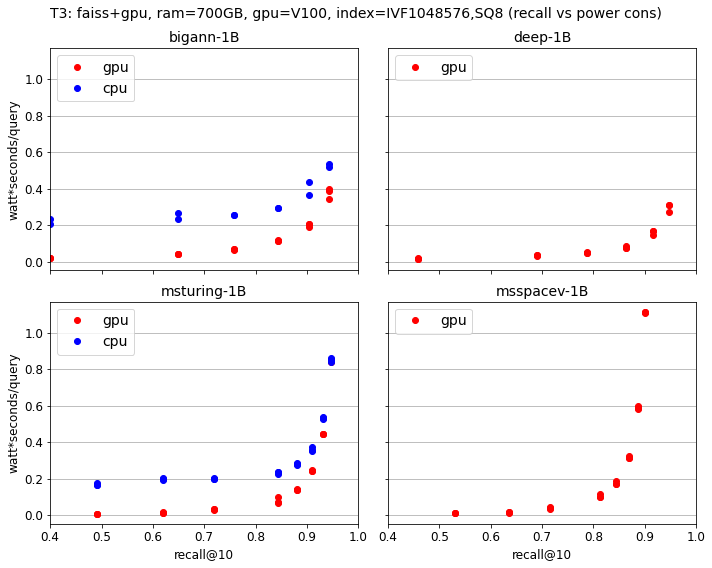

In [226]:
# Individual dbase plots
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=16, titlesize=16)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = 'roman'
#print(plt.rcParams.keys())

fig, axs = plt.subplots(2,2, sharey=True, sharex=True)

for d, idx in enumerate(expdata.keys()):
        
    for i,exp in enumerate(expdata[idx]['data']):
        recall = exp[0]
        qps = exp[1]
        wspq = exp[2]
        
        gpu_only=True
        gpu = expdata[idx]['gpu']
        if gpu[i]==1: 
            color = 'red'
        else: 
            gpu_only=False
            color='blue'  

        if d==0: 
            ax = axs[0,0]
            ax.set_ylabel("watt*seconds/query")
        elif d==1: 
            ax = axs[0,1] 
        elif d==2:    
            ax = axs[1,0]      
            ax.set_ylabel("watt*seconds/query")
            ax.set_xlabel("recall@10")
        elif d==3: 
            ax = axs[1,1]
            ax.set_xlabel("recall@10")
       
        shape = ax.plot(recall, wspq, '.', markersize=12, color=color)
        #ax.set_yscale('log')
        #ax.set_ylim([500,100000])
        #ax.set_yticks([1000,10000,100000])
        ax.set_xlim([0.4,1.0])
        ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
           
        if gpu[i]:
            gpu_shape = shape[0]
        else:
            cpu_shape = shape[0]
        
    ax.set_title(idx.replace("-T3","")) 
    ax.grid(axis = 'y')
    if gpu_only:
        ax.legend([gpu_shape,],['gpu',],loc='upper left', fontsize=14)
    else:
        ax.legend([gpu_shape, cpu_shape],['gpu','cpu'],loc='upper left', fontsize=14)
 
    plt.suptitle('T3: faiss+gpu, ram=700GB, gpu=V100, index=IVF1048576,SQ8 (recall vs power cons)')
   
plt.tight_layout()
plt.show()
fig.patch.set_alpha(1)
fig.savefig("recall_vs_wspq.png",facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)

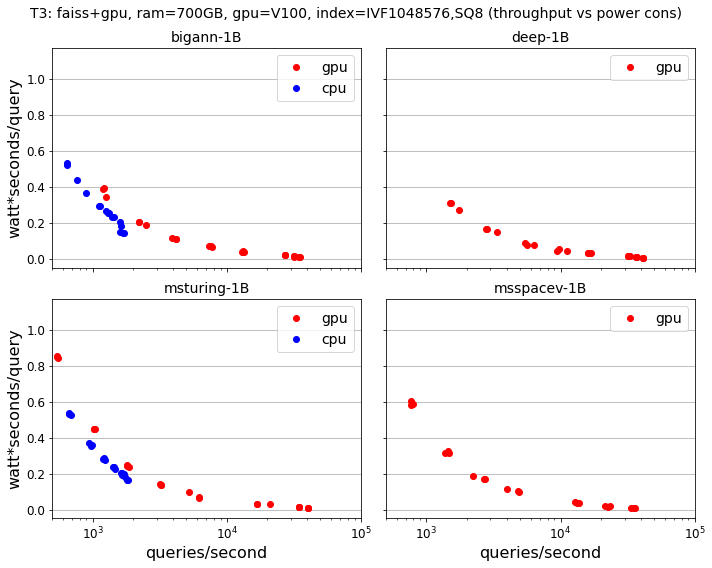

In [227]:
# Individual dbase plots
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=16, titlesize=16)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = 'roman'
#print(plt.rcParams.keys())

fig, axs = plt.subplots(2,2, sharey=True, sharex=True)

for d, idx in enumerate(expdata.keys()):
        
    for i,exp in enumerate(expdata[idx]['data']):
        recall = exp[0]
        qps = exp[1]
        wspq = exp[2]
        
        gpu_only=True
        gpu = expdata[idx]['gpu']
        if gpu[i]==1: 
            color = 'red'
        else: 
            gpu_only=False
            color='blue'  

        if d==0: 
            ax = axs[0,0]
            ax.set_ylabel("watt*seconds/query")
        elif d==1: 
            ax = axs[0,1] 
        elif d==2:    
            ax = axs[1,0]      
            ax.set_ylabel("watt*seconds/query")
            ax.set_xlabel("queries/second")
        elif d==3: 
            ax = axs[1,1]
            ax.set_xlabel("queries/second")
       
        shape = ax.plot(qps, wspq, '.', markersize=12, color=color)
        ax.set_xscale('log')
        ax.set_xlim([500,100000])
        ax.set_xticks([1000,10000,100000])
        #ax.set_xlim([0.4,1.0])
        #ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
           
        if gpu[i]:
            gpu_shape = shape[0]
        else:
            cpu_shape = shape[0]
        
    ax.set_title(idx.replace("-T3","")) 
    ax.grid(axis = 'y')
    if gpu_only:
        ax.legend([gpu_shape,],['gpu',],loc='upper right', fontsize=14)
    else:
        ax.legend([gpu_shape, cpu_shape],['gpu','cpu'],loc='upper right', fontsize=14)
 
    plt.suptitle('T3: faiss+gpu, ram=700GB, gpu=V100, index=IVF1048576,SQ8 (throughput vs power cons)')
   
plt.tight_layout()
plt.show()
fig.patch.set_alpha(1)
fig.savefig("throughput_vs_wspq.png",facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)

In [8]:
import pandas as pd
df= pd.DataFrame([list(range(5))], columns = [ str(I) for I in range(5)])

In [9]:
print(df)

   0  1  2  3  4
0  0  1  2  3  4


In [11]:
s = df.stack()
print(type(s))

<class 'pandas.core.series.Series'>
